## 引入模型

In [1]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout

In [2]:
class TextCNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=5,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        input = Input((self.maxlen,))
        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(input)
        convs = []
        for kernel_size in [3, 4, 5]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)

        output = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=input, outputs=output)
        return model

In [3]:
from tensorflow.keras.preprocessing import sequence
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [4]:
# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./Model/cnn_model.h5', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]

## 建立词表

In [5]:
file_proce_path = './Data/VersonData_2/traindf.csv'

In [6]:
import pandas as pd

In [7]:
traindf = pd.read_csv(file_proce_path,encoding='utf-8')
traindf.head()

,ID,Age,Gender,Education,Query List
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和 双沟 女生 中财网 首页 财经 周公 解梦 大全 查询 2345 曹云金 再讽 郭德纲...
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,广州 厨宝 烤箱 世情 人情 雨送 黄昏 花易落 风干 泪痕 厦门 酒店用品 批发市场 不想...
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,钻石 之泪 耳机 盘锦 沈阳 旅顺 公交 辽宁 阜新 车牌 baidu k715 k716 ...
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,受欢迎 狗狗 排行榜 场景 范例 三维 绘图 软件 酸奶 壮观 衣服 网站 动漫 绘图 软件...
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,干槽症 自愈 太太 万岁 舒心 美国 干槽症 眼皮 怎么回事 麦当劳 旋风 勺子 吉林市 鹿...


### age词表建立

In [8]:
agedf= traindf[['Age','Query List']]
agedf = agedf[agedf['Age']!=0]

In [9]:
agedf.head()

,Age,Query List
0,1,柔和 双沟 女生 中财网 首页 财经 周公 解梦 大全 查询 2345 曹云金 再讽 郭德纲...
1,2,广州 厨宝 烤箱 世情 人情 雨送 黄昏 花易落 风干 泪痕 厦门 酒店用品 批发市场 不想...
2,4,钻石 之泪 耳机 盘锦 沈阳 旅顺 公交 辽宁 阜新 车牌 baidu k715 k716 ...
3,4,受欢迎 狗狗 排行榜 场景 范例 三维 绘图 软件 酸奶 壮观 衣服 网站 动漫 绘图 软件...
4,2,干槽症 自愈 太太 万岁 舒心 美国 干槽症 眼皮 怎么回事 麦当劳 旋风 勺子 吉林市 鹿...


In [10]:
agedf.Age.value_counts()

1    38996
2    26744
3    18529
4    10654
5     2922
6      489
Name: Age, dtype: int64

In [19]:
X_age = agedf['Query List'].values.tolist()
Y_age = agedf['Age'].values.tolist()

In [11]:
import sys
from collections import Counter
import numpy as np
import tensorflow.keras as kr
import os

In [12]:
def build_vocab(train_data, vocab_file, vocab_size=5000):
    all_data = []
    for xage in train_data:
        all_data.extend(xage)
    print('all_data len is ',len(all_data))
    counter = Counter(all_data)
    print('couter len is  ',len(counter))
    count_pairs = counter.most_common(vocab_size - 1)
    words, _ = list(zip(*count_pairs))
    words = ['<PAD>'] + list(words) 
    with open(vocab_file,mode='w',encoding='utf-8') as f:
        f.write('\n'.join(words) + '\n')
    print('file write over')

In [13]:
vocab_file_age = './Data/VersonData_4/vocab_file_age'
vocab_file_gender = './Data/VersonData_4/vocab_file_gender'
vocab_file_education = './Data/VersonData_4/vocab_file_education'

In [15]:
#build_vocab(X_age,vocab_file_age,vocab_size = 40000)

all_data len is  118713277
couter len is   6331
file write over


In [14]:
def read_vocab(vocab_file):
    """读取词汇表"""
    # words = open_file(vocab_dir).read().strip().split('\n')
    with open(vocab_file,mode='r',encoding='utf-8') as fp:
        # 如果是py2 则每个值都转化为unicode
        words = [_.strip() for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

In [15]:
words, word_to_id = read_vocab(vocab_file_age)

In [16]:
def encode_cate(content, words):
    """将id表示的内容转换为文字"""
    return [(words[x] if x in words else 40000) for x in content]

In [17]:
def encode_sentences(contents, words):
    """将id表示的内容转换为文字"""
    return [encode_cate(x,words) for x in contents]

数据打乱

In [20]:
data = list(zip(X_age,Y_age))

In [21]:
import random

In [22]:
random.shuffle(data)

In [23]:
X_ages,Y_ages = zip(*data)

In [24]:
x_train, x_test,y_train,y_test = train_test_split(X_ages,Y_ages)

In [25]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

73750
24584
73750
24584


In [33]:
print(y_train[0:10])

[3, 2, 2, 1, 1, 1, 2, 1, 1, 2]


In [30]:
cat_to_id = {1:0,2:1,3:2,4:3,5:4,6:5}

In [34]:
xs_train = encode_sentences([content[0] for content in x_train], word_to_id)
ys_train = to_categorical(encode_cate(y_train, cat_to_id))
xs_test = encode_sentences([content[0] for content in x_test], word_to_id)
ys_test = to_categorical(encode_cate(y_test, cat_to_id))

In [27]:
# 神经网络配置
max_features = 40001
maxlen = 100
batch_size = 256
embedding_dims = 50
epochs = 8
vocab_size = 40000

In [35]:
print('对序列做padding，保证是 samples*timestep 的维度')
xs_train = sequence.pad_sequences(xs_train, maxlen=maxlen)
xs_test = sequence.pad_sequences(xs_test, maxlen=maxlen)
print('x_train shape:', xs_train.shape)
print('x_test shape:', xs_test.shape)

对序列做padding，保证是 samples*timestep 的维度
x_train shape: (73750, 100)
x_test shape: (24584, 100)


In [36]:
print('ys_test shape:', ys_test.shape)

ys_test shape: (24584, 6)


In [37]:
print('构建模型...')
model = TextCNN(maxlen, max_features, embedding_dims,class_num=6).get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

构建模型...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [38]:
#跑这里电脑就不行 垃圾电脑
# fit拟合数据
history = model.fit(xs_train, ys_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(xs_test, ys_test))

Train on 73750 samples, validate on 24584 samples
Epoch 1/8
73216/73750 [============================>.] - ETA: 0s - loss: 1.4123 - acc: 0.3959
Epoch 00001: saving model to ./Model/cnn_model.h5
73750/73750 [==============================] - 7s 98us/sample - loss: 1.4120 - acc: 0.3957 - val_loss: 1.3911 - val_acc: 0.3990
Epoch 2/8
73216/73750 [============================>.] - ETA: 0s - loss: 1.3790 - acc: 0.4044
Epoch 00002: saving model to ./Model/cnn_model.h5
73750/73750 [==============================] - 6s 79us/sample - loss: 1.3789 - acc: 0.4044 - val_loss: 1.3908 - val_acc: 0.3907
Epoch 3/8
73216/73750 [============================>.] - ETA: 0s - loss: 1.3650 - acc: 0.4147
Epoch 00003: saving model to ./Model/cnn_model.h5
73750/73750 [==============================] - 6s 79us/sample - loss: 1.3647 - acc: 0.4148 - val_loss: 1.3959 - val_acc: 0.3932
Epoch 4/8
73216/73750 [============================>.] - ETA: 0s - loss: 1.3534 - acc: 0.4196
Epoch 00004: saving model to ./Model/cnn

In [36]:
os.environ['CUDA_VISIBLE_DEVICES'] = '/gpu:0'

In [39]:
import matplotlib.pyplot as plt 
plt.switch_backend('agg')
%matplotlib inline

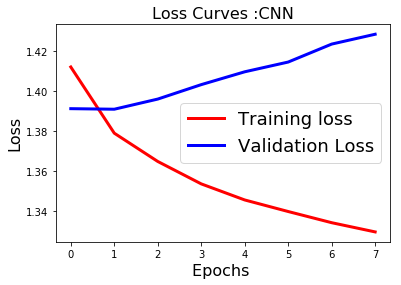

In [40]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
#fig1.savefig('../../tmp/loss_cnn.png')
plt.show()

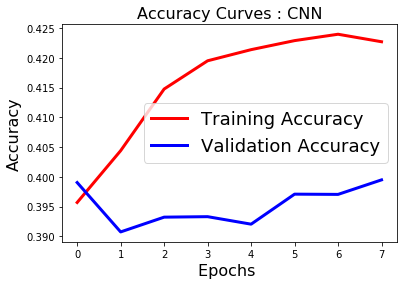

In [41]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
#fig2.savefig('../../tmp/accuracy_cnn.png')
plt.show()

### 性别隔离

In [42]:
genderdf = traindf[['Age','Query List','Gender']]
genderdf = genderdf[genderdf['Gender']!= 0]

In [43]:
X_gender = genderdf['Query List'].values.tolist()
Y_gender = genderdf['Gender'].values.tolist() 
Y_ageflg = genderdf['Age'].values.tolist() 

In [44]:
build_vocab(X_gender,vocab_file_gender,vocab_size = 40000)

all_data len is  118124264
couter len is   6329
file write over


### 教育隔离

In [45]:
educationdf = traindf[['Education','Query List']]
educationdf = educationdf[educationdf['Education']!=0]

In [46]:
X_education = educationdf['Query List'].values.tolist()
Y_education = educationdf['Education'].values.tolist() 

In [47]:
build_vocab(X_education,vocab_file_education,vocab_size = 40000)

all_data len is  109414021
couter len is   6305
file write over
